# CSE 144 Spring 2022 Assignment 3

In this assignment, the goal is to train SVM models to fit the generated data. 

## Data generation

You are provided with a synthetic dataset generated by the make blobs() function from the scikit-learn package. The code to generate and split the dataset is included. When you work on the assignment, please do not modify the data generation code (i.e., the first cell in the notebook). The dataset contains a set of 2-d features xi = (xi1,xi2) with binary labels yi ∈ {−1,1}.

(128, 2) (128,)
(32, 2) (32,)
(40, 2) (40,)


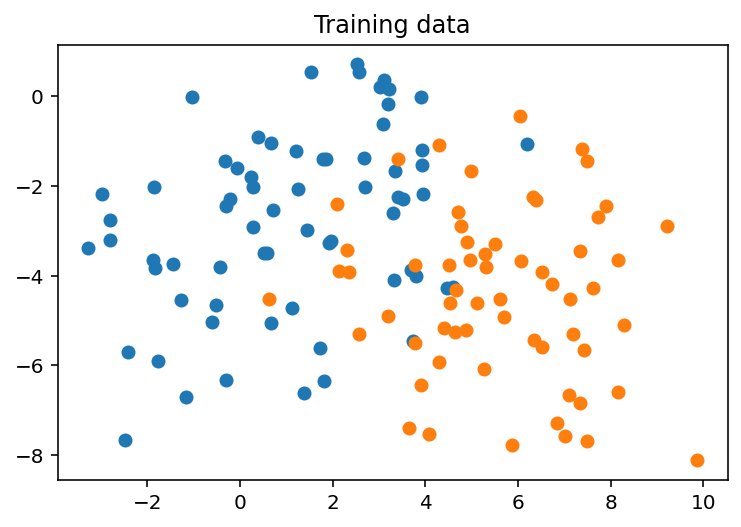

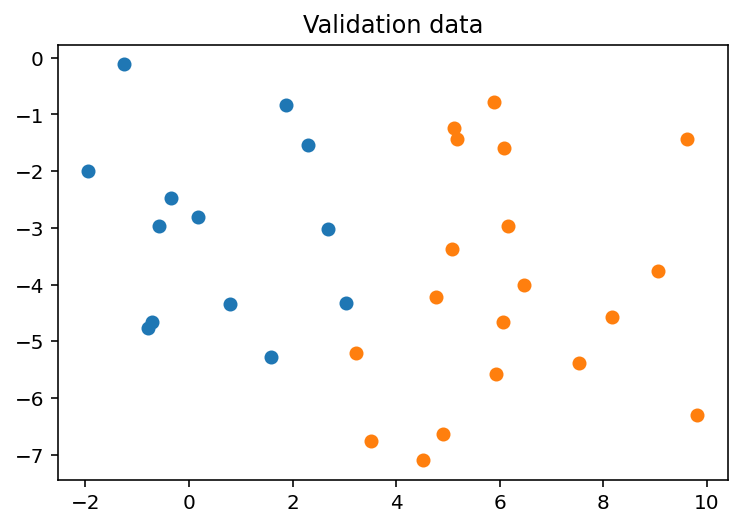

In [183]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format="retina"


def plot_data(x: np.ndarray, y: np.ndarray) -> None:
    class0_idx = np.where(y == -1)[0]
    class1_idx = np.where(y == 1)[0]
    feature0 = x[:, 0]
    feature1 = x[:, 1]
    plt.scatter(feature0[class0_idx], feature1[class0_idx], label="-1")
    plt.scatter(feature0[class1_idx], feature1[class1_idx], label="1")


def modify_label(label):
    return np.array([-1 if i == 0 else 1 for i in label])


x, y = make_blobs(
    n_samples=200,
    n_features=2,
    centers=2,
    cluster_std=2,
    center_box=(-9, 9),
    random_state=1645,
)


x_train_val, x_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, random_state=288
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=288
)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

y_train, y_val, y_test = map(modify_label, [y_train, y_val, y_test])

plot_data(x_train, y_train)
plt.title("Training data")
plt.show()
plot_data(x_val, y_val)
plt.title("Validation data")
plt.show()

From the data visualization, we can find that the data is not linearly separable. There are two solutions for this: 

1. SVM with soft margin.
2. Solve dual formation of SVM, and use kernel tricks.


For SVM with soft margin, we add 'slack' variable at the beginning, which changes the target problem. This happens to convert the original constrained optimization problem to an unconstrained optimization problem. Therefore, it is convenient for us to do gradient descent directly. Of course, we can also continue solving the dual of this instead.

For SVM with hard margin, typically we just solve the dual problem because it's hard to solve the constrained problem. Suppose we have a dual formation of SVM with either hard or soft margin, we can use a kernel trick to project low-dimension data point to high-dimension space. The first benefit is that we can easily find a hyperplane in high-dimension space to seperate data points. The second benefit is that since the only term related to features is like $x_i^Tx_j$, so if we use $\phi(x_i)$ and $\phi(x_j)$ instead of $x_i$ and $x_j$, then it's sufficient to know $\phi(x_i)^T\phi(x_j)$. This means that we need not know the specific definition of $\phi()$. Just picking a kernel function $\kappa: \mathbb{R}^d\times\mathbb{R}^d\rightarrow \mathbb{R}$ such that there exists $\phi(): \kappa(x_1,x_2)=\phi(x_1)^T\phi(x_2)$ is enough.

In the following, we will implement these two variants of SVM.

## SVM with soft margin (53')

In [184]:
class SVMTrainer:
    def __init__(
        self,
        num_examples: int,
        num_features: int = 2,
        learning_rate: float = 1e-2,
        num_epochs: int = 250,
        c: float = 0.5,
        penalty: float = 100
    ) -> None:
        """Initialize a support vector machine trainer."""
        self.c = c
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_examples = num_examples
        self.num_features = num_features

        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.test_loss = None
        self.test_acc = None

        # Initialize weights and bias. Depenending on your approach, you can either
        # initialize w and b separately or theta as a single vector. 
        # ========== YOUR CODE STARTS HERE ========== 3'
        # so weights should be shape(num_of_cols,1) so we can do w^T @ x_train and modifty them
        self.theta = np.zeros(num_features)
        # self.theta = np.reshape(self.theta,(self.theta.size,1))
        #b should be a scalar
        self.b = 1;
        # ========== YOUR CODE ENDS HERE ==========


    def hinge_loss(self, pred, target) -> float:
        """
        Calculates the hinge loss given predictions and targets.

        Args:
            pred: Predicted labels.
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        #if doesnt work, use a for loop and try again
        #print(self.theta.shape)
        #print(pred.shape)
        hinge_loss_A = 1/(2*len(pred)) * (self.theta.transpose() @ self.theta)
        hinge_loss_Arg = 1- pred * target
        return self.c * np.sum(np.maximum(0,hinge_loss_Arg) + hinge_loss_A)
        
        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss_derivative(self, x, y) -> np.ndarray:
        """
        Calculate the derivative of the loss function w.r.t. theta.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        #will return an array and a float since I separated b and w
        # apply gradient condition to theta and b
        #print(self.theta.shape)
        condition = 1- y * (x@self.theta +self.b) > 0
        #print(condition)
        # y = np.reshape(y,(y.size,1))
        # x = np.reshape(x,(x.size,1))
        #print(x.shape)
        if(condition == True):
          dt = self.theta/x.size - self.c * x * y
          #print(y.shape)
          #print(self.theta.shape)
          #print(dt.shape)
          db = -self.c * y
          #calculate gradient and put it into vector to return

        else:
          dt = self.theta / x.size
          db = 0
          #calculate gradient and put it into vector
       

        return dt,db
        # ========== YOUR CODE ENDS HERE ==========

    def accuracy(self, pred, target) -> float:
        """
        Calculates the percentage of matched labels given predictions and targets.

        Args:
            pred: Predicted labels (rounded probabilities).
            target: Ground-truth labels.

        Return:
            The accuracy score (a float) given the predicted labels and the true labels.
        """
        # ========== YOUR CODE STARTS HERE ========== 3'
        pred = np.round(pred)
        trutharray = np.equal(pred,target)
        # print(pred)
        # print(target)
        #print(trutharray)
        n = len(pred)
        #count the number of nonzero values
      
        numtruth = np.sum(trutharray)
        accuracy = numtruth / n
        return accuracy
        # ========== YOUR CODE ENDS HERE ==========

    def predict(self, x) -> int:
        """
        Predict the label of input examples x.

        Args:
            x: Feature vectors.

        Returns:
            A scalar of either -1 or 1.
        """
        # ========== YOUR CODE STARTS HERE ========== 3'
        #print(x)
        return np.sign((x@self.theta) + self.b)
        # ========== YOUR CODE ENDS HERE ==========

    def train(self, x_train, y_train, x_val, y_val) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. In every epoch,
            1. Update theta.
            2. Calculate the training loss & accuracy given the current theta, and append 
               then to self.train_loss_history and self.train_acc_history.
            3. Calculate the validation loss & accuracy given the current theta, and 
               append then to self.train_loss_history and self.train_acc_history.

        If you wish to use the bias trick, please remember to use it before the for loop.

        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """
        # ========== YOUR CODE STARTS HERE ========== 10'
        #reshape y's because they are messed up
        y_train = np.reshape(y_train,(y_train.size,1))
        y_val = np.reshape(y_val,(y_val.size,1))
        #initialize loss vectors
        #print(x_train.shape)
        for epoch in range(self.num_epochs):
          #do gradient descent step and calculate weights and losses
          for i in range(len(x_train)):
            weight, bias = self.hinge_loss_derivative(x_train[i], y_train[i])
            self.theta -= self.learning_rate * weight
            self.b -= self.learning_rate * bias
        
          #calculate the prediction vectors
          train_loss_pred = [self.predict(x_train[n]) for n in range(len(x_train))]
          val_loss_pred = [self.predict(x_val[r]) for r in range(len(x_val))]
          train_loss = self.hinge_loss(train_loss_pred,y_train)
          #train_loss = train_loss[0][0]
          #print(train_loss)
          #print(train_loss)
          val_loss = self.hinge_loss(val_loss_pred,y_val)
          #val_loss = val_loss[0][0]
          #append train lost and accuracy
          self.train_loss_history.append(train_loss)
          self.val_loss_history.append(val_loss)
          #calculate val loss and accuracy
          train_acc = self.accuracy(train_loss_pred,y_train)
          val_acc = self.accuracy(val_loss_pred,y_val)
          # Record training accuracy
          self.train_acc_history.append(train_acc)
          #Record validation accuracy
          self.val_acc_history.append(val_acc)
        # ========== YOUR CODE ENDS HERE ==========

    def evaluate(self, x_test, y_test) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """
        # ========== YOUR CODE STARTS HERE ========== 3'
        #bias trick pt 2 electric boogaloo
        #x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

        #calculate test loss
        self.test_loss = self.hinge_loss(self.predict(x_test),y_test)
        #calculate test accuracy
        self.test_acc = self.accuracy(self.predict(x_test),y_test)

        # ========== YOUR CODE ENDS HERE ==========

    def compute_support_vectors(self, x, y) -> np.ndarray:
        """
        Compute support vectors given training data x and y.

        Args:
            x_test: Feature vectors.
            y_test: Ground-truth labels.

        Returns:
            A NumPy array of support vectors.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        #truth val for support vector

        truth_val = 1-y*(x @ self.theta + self.b)
        return x[np.where(truth_val > 0)]
        # ========== YOUR CODE ENDS HERE ==========

Final train loss: 14.043708243990295
Final validation loss: 0.04370824399029437
Final train acc: 0.890625
Final validation acc: 1.0


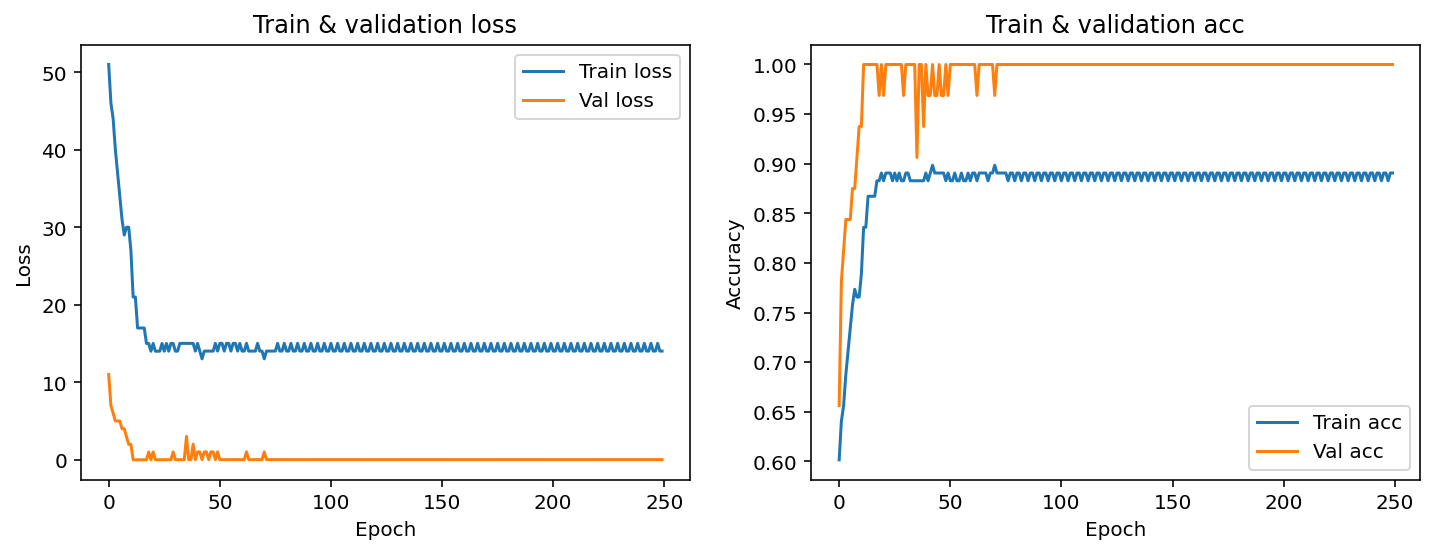

In [185]:
# train SVM with soft margin on our data
# ========== YOUR CODE STARTS HERE ========== 3'
soft_trainer = SVMTrainer(num_examples = 1)
soft_trainer.train(x_train,y_train,x_val,y_val)
# ========== YOUR CODE ENDS HERE ==========

print(f"Final train loss: {soft_trainer.train_loss_history[-1]}")
print(f"Final validation loss: {soft_trainer.val_loss_history[-1]}")
print(f"Final train acc: {soft_trainer.train_acc_history[-1]}")
print(f"Final validation acc: {soft_trainer.val_acc_history[-1]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(len(soft_trainer.train_loss_history)), soft_trainer.train_loss_history, label="Train loss")
ax[0].plot(np.arange(len(soft_trainer.val_loss_history)), soft_trainer.val_loss_history, label="Val loss")
ax[0].set_title("Train & validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(np.arange(len(soft_trainer.train_loss_history)), soft_trainer.train_acc_history, label="Train acc")
ax[1].plot(np.arange(len(soft_trainer.val_loss_history)), soft_trainer.val_acc_history, label="Val acc")
ax[1].set_title("Train & validation acc")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

In [186]:
def plot_decision_boundary(w, b, x) -> None:
    """
    Plot the decision boundary and margin using w and b. Use this function with 
    plot_data().

    Args:
        w: weights, a vector of length 2.
        b: bias, a scalar.
        x: 2-d feature vectors.
    """
    # ========== YOUR CODE STARTS HERE ========== 8'
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (b) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
    # 2-d.
    margin = 1 / np.sqrt(np.sum(w**2))
    yy_down = yy - np.sqrt(1 + a**2) * margin
    yy_up = yy + np.sqrt(1 + a**2) * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.clf()
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")
    
    # ========== YOUR CODE ENDS HERE ==========

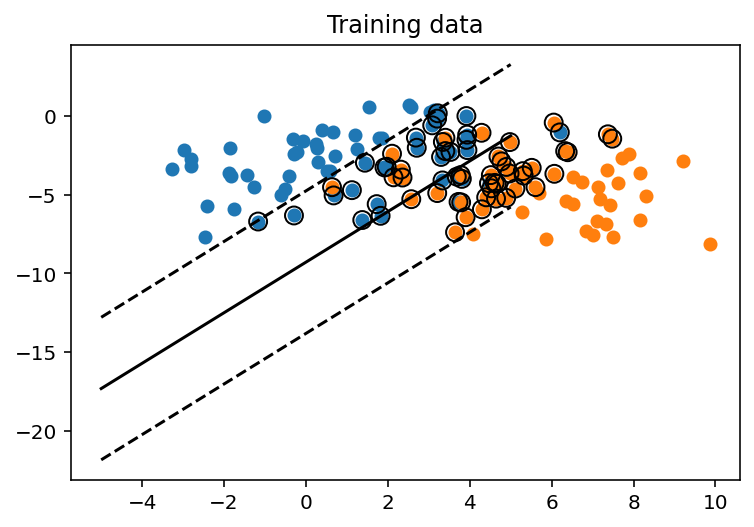

In [187]:
# Plot the training data along with decision boundary and margin and support vectors
# ========== YOUR CODE STARTS HERE ========== 5'
from matplotlib import cm
supportvec = soft_trainer.compute_support_vectors(x_train,y_train)
plot_decision_boundary(soft_trainer.theta,soft_trainer.b,x_train)
plt.scatter(
        supportvec[:, 0],
        supportvec[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
        cmap=cm.get_cmap("RdBu"),
    )
plot_data(x_train, y_train)
plt.title("Training data")
plt.show()
# ========== YOUR CODE ENDS HERE ==========

## Dual of hard-margin SVM with kernel trick (41')

In this section, you are required to solve duality formation of SVM with kernel trick. Choose appropriate kernel function to get convergence. 

Hint: different kernels only influent loss function and gradient.

In [188]:
class DualSVMTrainer(SVMTrainer):
    def __init__(self, penalty=1.0, **kwargs):
        super().__init__(**kwargs)
        self.penalty = penalty

        # Initialize model parameters alpha.
        # ========== YOUR CODE STARTS HERE ========== 3'
        self.alpha = np.ones(self.num_examples)
        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss(self, x, y) -> float:
        """
        Calculates the hinge loss given predictions and targets.

        Args:
            pred: Predicted labels.
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        alphavar = -np.sum(self.alpha)
        size = len(x)
        # do double for loop since idk how to vectorize 
        sum = 0
        for i in range(size):
          for j in range(size):
            sum += self.alpha[i] * self.alpha[j]*y[i]*y[j]*(np.dot(x[i].T,x[j]))
        #add penalty value to it 
        return (1/2)*sum +alphavar
        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss_derivative(self, x, y) -> np.ndarray:
        """
        Calculate the derivative of the loss function w.r.t. theta.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        size = x.shape[0]
        #first for loop
        #new alpha array so we don't change alpha before we need it
        newAlpha = np.empty(len(self.alpha))
        for i in range(size):
          #we can vectorize the second loop
          newAlpha[i] = -1 + (2 * np.sum(self.alpha * y * y[i] * (x @ x[i])))
          #from piazza post regarding penalty
          newAlpha[i]+= 2 * self.penalty*np.sum(self.alpha * y) * y[i]
        return newAlpha
        # ========== YOUR CODE ENDS HERE ==========

    def compute_bw(self, x, y):
        """
        Compute weights and bias given model parameter self.alpha, and training data x
        and y.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        #calculate for w (from piazza post)
        size = x.shape[0]
        #print(x.shape)
        #print(y.shape)
        w = np.zeros(self.num_features)
        for i in range(self.num_features):
            w[i]= np.sum(self.alpha * y * x[:, i])
        #print(w.shape)
        #calculate for bias (from piazza post)
        b = (1/size) * np.sum(y - (x@w))
        return w,b
        # ========== YOUR CODE ENDS HERE ==========

    def train(self, x_train, y_train, x_val, y_val) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. In every epoch,
            1. Update theta.
            2. Calculate the training loss & accuracy given the current theta, and append 
               then to self.train_loss_history and self.train_acc_history.
            3. Calculate the validation loss & accuracy given the current theta, and 
               append then to self.train_loss_history and self.train_acc_history.

        If you wish to use the bias trick, please remember to use it before the for loop.

        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """
        # ========== YOUR CODE STARTS HERE ========== 10`
        # start training loop
        for epoch in range(self.num_epochs):
          #do gradient descent step for alpha
          self.alpha = self.alpha - self.learning_rate * (self.hinge_loss_derivative(x_train,y_train))
          #we are using a hard margin, so we take the maximum 
          #self.alpha = np.maximum(self.alpha,0)
          #for soft margin
          self.alpha = np.clip(self.alpha,0,self.c)
          #compute weights and bias after 
          w,b = self.compute_bw(x_train,y_train)
          #set weights and bias
          self.w = w
          self.b = b
          #calculate the prediction vectors
          train_loss_pred = self.predict(x_train)
          val_loss_pred = self.predict(x_val)
          #calculate train loss
          train_loss = self.hinge_loss(train_loss_pred,y_train)
          #calculate val loss
          val_loss = self.hinge_loss(val_loss_pred,y_val)
          #append train lost and accuracy
          self.train_loss_history.append(train_loss)
          self.val_loss_history.append(val_loss)
          #calculate val loss and accuracy
          train_acc = self.accuracy(train_loss_pred,y_train)
          val_acc = self.accuracy(val_loss_pred,y_val)
          # Record training accuracy
          self.train_acc_history.append(train_acc)
          #Record validation accuracy
          self.val_acc_history.append(val_acc)

        # ========== YOUR CODE ENDS HERE ==========

    def evaluate(self, x_test, y_test) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        #evaluating on test set
        self.test_loss = self.hinge_loss(self.predict(x_test),y_test)
        #calculate test accuracy
        self.test_acc = self.accuracy(self.predict(x_test),y_test)
        # ========== YOUR CODE ENDS HERE ==========

Final train loss: -5.714280686361332
Final validation loss: -6.662030332545794
Final train acc: 0.5234375
Final validation acc: 0.40625


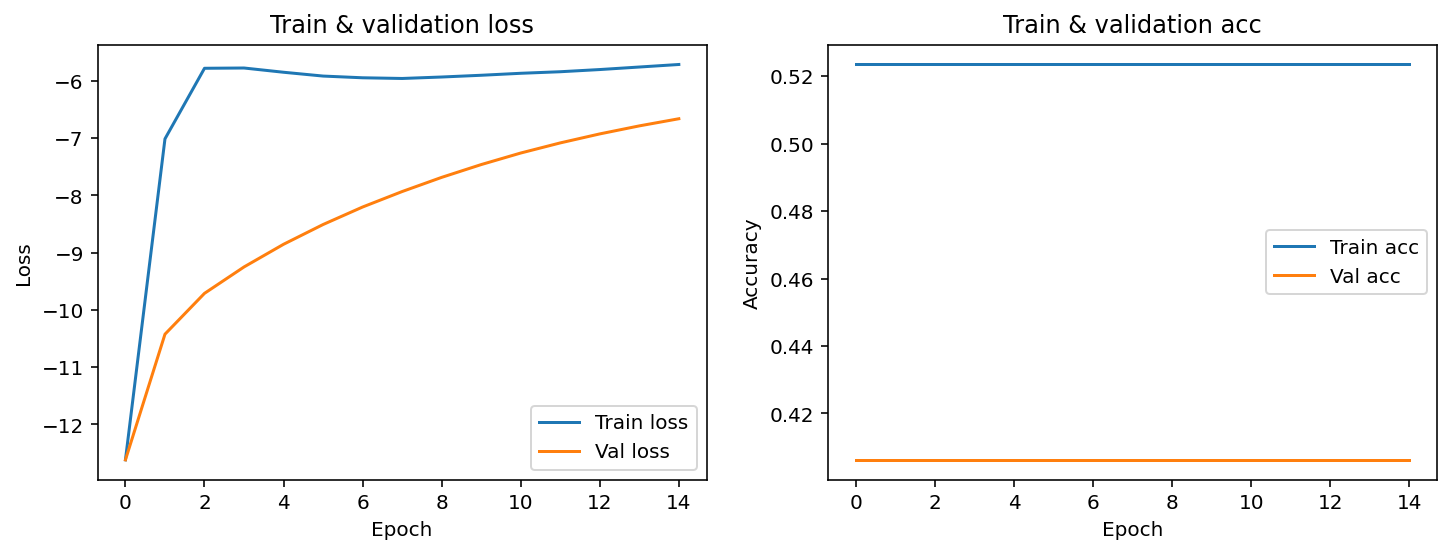

In [189]:
# Train SVM dual with kernel trick
# ========== YOUR CODE STARTS HERE ========== 3'
hard_dual_trainer = DualSVMTrainer(num_examples=128, learning_rate=1e-4, num_epochs=15, c=1e-1, penalty=10)
hard_dual_trainer.train(x_train,y_train,x_val,y_val)
# ========== YOUR CODE ENDS HERE ==========

print(f"Final train loss: {hard_dual_trainer.train_loss_history[-1]}")
print(f"Final validation loss: {hard_dual_trainer.val_loss_history[-1]}")
print(f"Final train acc: {hard_dual_trainer.train_acc_history[-1]}")
print(f"Final validation acc: {hard_dual_trainer.val_acc_history[-1]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(len(hard_dual_trainer.train_loss_history)), hard_dual_trainer.train_loss_history, label="Train loss")
ax[0].plot(np.arange(len(hard_dual_trainer.val_loss_history)), hard_dual_trainer.val_loss_history, label="Val loss")
ax[0].set_title("Train & validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(np.arange(len(hard_dual_trainer.train_loss_history)), hard_dual_trainer.train_acc_history, label="Train acc")
ax[1].plot(np.arange(len(hard_dual_trainer.val_loss_history)), hard_dual_trainer.val_acc_history, label="Val acc")
ax[1].set_title("Train & validation acc")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

In [190]:
#need function to plot decision boundary
def plot_decision_boundary_hard(w,b,x) -> None:
    a = -w[0] /w[1]
    xx = np.linspace(-5,10)
    yy = a*xx - b /w[1]
    plt.clf()
    plt.plot(xx,yy,'k-')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


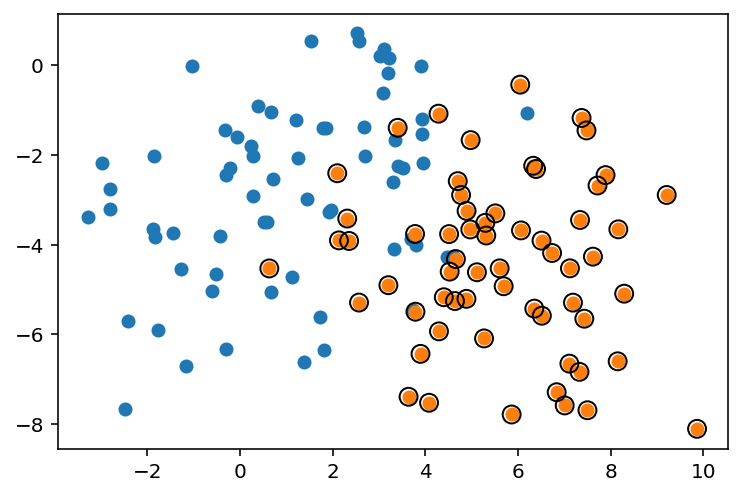

In [198]:

# Plot the training data along with decision boundary and margin and support vectors
# ========== YOUR CODE STARTS HERE ========== 5'
from matplotlib import cm

supportvec = hard_dual_trainer.compute_support_vectors(x_train,y_train)
plot_decision_boundary_hard(hard_dual_trainer.theta,hard_dual_trainer.b,supportvec)
plt.scatter(
    supportvec[:,0],
    supportvec[:,1],
    s= 80,
    facecolors="none",
    zorder=10,
    cmap=cm.get_cmap('RdBu'),
    edgecolors = "k"
)
plot_data(x_train,y_train)
#I can't figure out why the decision boundary won't print correctly 
# ========== YOUR CODE ENDS HERE ==========

## Evaluation (6')

In [192]:
# Evaluate your model on the test set
# ========== YOUR CODE STARTS HERE ========== 3'
soft_trainer.evaluate(x_test,y_test)
# ========== YOUR CODE ENDS HERE ==========
print(f"Test loss: {soft_trainer.test_loss}")
print(f"Test acc: {soft_trainer.test_acc}")

Test loss: 3.043708243990295
Test acc: 0.925


In [193]:
# ========== YOUR CODE STARTS HERE ========== 3'
hard_dual_trainer.evaluate(x_test,y_test)
# ========== YOUR CODE ENDS HERE ==========
print(f"Test loss: {hard_dual_trainer.test_loss}")
print(f"Test acc: {hard_dual_trainer.test_acc}")

Test loss: -6.661054748346148
Test acc: 0.5
